In [58]:
import pandas as pd
import numpy as np
from fastai.structured import *
from fastai.column_data import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from metrics import print_metrics_binary
import matplotlib.pyplot as plt
#from tqdm import TqdmSynchronisationWarning
np.set_printoptions(threshold=50, edgeitems=20)

In [59]:
#print(torch.cuda.current_device())
#torch.cuda.set_device(1)

In [60]:
#warnings.filterwarnings("ignore", category=TqdmSynchronisationWarning)

In [61]:
train = pd.read_csv('./datasets/ihm/train.csv')
test = pd.read_csv('./datasets/ihm/test.csv')
val = pd.read_csv('./datasets/ihm/val.csv')
train = train.drop('Unnamed: 0', axis=1)
test = test.drop('Unnamed: 0', axis=1)
val = val.drop('Unnamed: 0', axis=1)

In [62]:
def balance_dataset(df):
    split_set = []
    num_survived = 0
    num_died = 0
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
        if df_episode.iloc[0]['Mortality'] < 1:
            num_survived = num_survived +1
        else:
            num_died = num_died +1
    counter = 0
    for patient in split_set:
        if patient.iloc[0]['Mortality'] == 1 and num_died*2 > counter:
            new_patient = patient.copy()
            new_patient["Episode"] = ("e" + str(counter))
            split_set.append(patient)
            counter = counter +1
    print(num_died+counter, num_survived)
    complete_data =  pd.DataFrame(columns=df.columns)
    complete_data = pd.concat(split_set)
    return complete_data




train_balanced = balance_dataset(train)

5961 12694


In [63]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))


print(len(val[val['Mortality'] == 1]))
print(len(val[val['Mortality'] == 0]))


541776
1014121
38996
224337


In [64]:
def split_df(df):
    split_set = []
    for episode, df_episode in df.groupby('Episode'):
        split_set.append(df_episode)
    return split_set

train_split = split_df(train)




In [65]:
def plot_episode_lengths(df):
    patient_lengths = []
    for patient in df:
        patient_lengths.append(len(patient))
    plt.hist(patient_lengths,200)
    plt.axis([0,200,0,10000])
    plt.show()

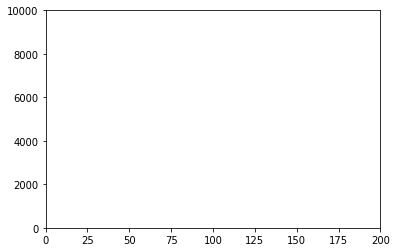

In [67]:



def make_episode_to_single_row(df, rows):
    
    new_data  = []
    for patient in train_split:
        length = len(patient)
        if length < 30 : 
            continue
        elif length < rows:
            duplicate_data = []
            while length < rows:
                duplicate_data.append(patient.iloc[0])
                length=length+1
            new_data.append(pd.concat([pd.DataFrame(duplicate_data), patient], ignore_index=True))
        elif length > rows:
            new_data.append(patient.iloc[length-rows:])
            length-rows
        else: 
            new_data.append(patient)
    return new_data

train_split = make_episode_to_single_row(train_split, 100)

plot_episode_lengths(train_split)
        

100

In [8]:
train_size = len(train_balanced)
train_balanced = train_balanced.append(val)


print(train_size)
print(len(train_balanced))
val_idx = list(range(train_size, len(train_balanced)))

1555897
1819230


In [9]:
cat_vars = ['Capillary refill rate', 'Glascow coma scale eye opening' ,'Glascow coma scale motor response','Glascow coma scale total', 'Glascow coma scale verbal response','Episode' ]


for v in cat_vars: train_balanced[v] = train_balanced[v].astype('category').cat.as_ordered()
for v in cat_vars: test[v] = test[v].astype('category').cat.as_ordered()

cat_sz = [(c, len(train_balanced[c].cat.categories)+1) for c in cat_vars]

print(cat_sz)

emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

[('Capillary refill rate', 3), ('Glascow coma scale eye opening', 6), ('Glascow coma scale motor response', 7), ('Glascow coma scale total', 14), ('Glascow coma scale verbal response', 6), ('Episode', 17904)]


In [10]:
print(len(train_balanced[train_balanced['Mortality'] == 1]))
print(len(train_balanced[train_balanced['Mortality'] == 0]))

580772
1238458


In [11]:
df, y, nas, mapper = proc_df(train_balanced, 'Mortality', do_scale=True)
df_test, y_test, nas_test, mapper_test = proc_df(test, do_scale=True, mapper=mapper, na_dict=nas) 

md = ColumnarModelData.from_data_frame('./datasets/ihm/', val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=256,
                                       test_df=df_test)

In [12]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.9, 1, [1000,500,250], [0.7,0.6,0.5], y_range=[0,1], crit = torch.nn.functional.binary_cross_entropy)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 54%|█████▍    | 3300/6078 [00:22<00:19, 145.13it/s, loss=0.2]   

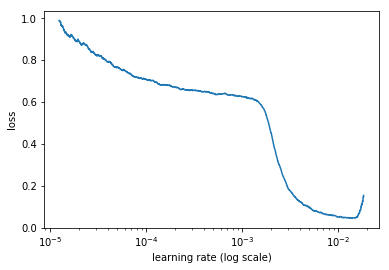

In [13]:
m.lr_find()
m.sched.plot(100)


In [17]:
lr = 0.0001


def roc_auc(preds, y):
    preds = np.exp(preds) #conv from log
    return metrics.roc_auc_score(y, preds, average="micro")

def accuracy1(preds, targs):
    #if np.array(targs.long()).max() == 1:
        #print(preds, targs)
    #print ('preds: {}, {}'.format(preds.ceil() ,type(preds)))
    #print ('targs: {}, {}'.format(targs.ceil() ,type(targs)))
    return (preds.long()==targs.long()).float().mean()


In [18]:
lrs = [lr/18, lr/9, lr/6]

In [19]:
m.fit(lr, 2, cycle_len=1, cycle_mult=2, metrics=[accuracy1])

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy1                      
    0      0.619608   0.562051   0.851914  
    1      0.132684   0.514996   0.851914                       
 22%|██▏       | 1334/6078 [00:09<00:32, 144.89it/s, loss=0.104]

KeyboardInterrupt: 

In [20]:


test_split = split_test_set(df_test)

In [21]:

m.Precompute = False
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())
    

 22%|██▏       | 1334/6078 [00:20<01:11, 66.70it/s, loss=0.104] 500/3236
1000/3236
1500/3236
2000/3236
2500/3236
3000/3236


In [22]:
preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)

In [23]:
print_metrics_binary(y_true, preds)


confusion matrix:
[[2452  410]
 [ 316   58]]
accuracy = 0.77564895
precision class 0 = 0.88583815
precision class 1 = 0.123931624
recall class 0 = 0.8567435
recall calss 1 = 0.15508021
AUC of PRC = 0.18833162967170092
min(+P, Se) = 0.12393162393162394


{'acc': 0.77564895,
 'auprc': 0.18833162967170092,
 'minpse': 0.12393162393162394,
 'prec0': 0.88583815,
 'prec1': 0.123931624,
 'rec0': 0.8567435,
 'rec1': 0.15508021}

In [ ]:
m.fit(lrs, 2, cycle_len=2, cycle_mult=3, metrics=[accuracy1])

In [ ]:
y_true = []
counter = 1
y_predicted = []
for patient in test_split:
    if counter % 500 == 0:
        print(str(counter) + '/' + str(len(test_split)))
    counter=counter+1
    y = patient['Mortality'].iloc[0]
    y_true.append(y)
    p = ColumnarDataset.from_data_frame(patient.drop('Mortality', axis=1),cat_flds=cat_vars)
    y_predicted.append(m.predict_dl(DataLoader(p)).max())

preds = []
for pred in y_predicted:
    if pred > 0.5: 
        preds.append(1)
    else: 
        preds.append(0)
        
print_metrics_binary(y_true, preds)